In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Trainyolo')

In [3]:
import os
import xml.etree.ElementTree as ET
from PIL import Image


labels_dir = 'dataset/labels/train'
images_dir = 'dataset/images/train'
output_dir = 'dataset/annotations/train'


os.makedirs(output_dir, exist_ok=True)


class_names = ["Containership", "Fishing_Vassel", "sailboat", "cruiseship", "dingyboat", "tugboat", "Yacht"]

def yolo_to_voc(yolo_bbox, img_width, img_height):
    x_center, y_center, width, height = yolo_bbox
    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    xmin = int(x_center - width / 2)
    ymin = int(y_center - height / 2)
    xmax = int(x_center + width / 2)
    ymax = int(y_center + height / 2)

    return [xmin, ymin, xmax, ymax]

for label_file in os.listdir(labels_dir):

    image_file = os.path.join(images_dir, label_file.replace('.txt', '.png'))
    img = Image.open(image_file)
    img_width, img_height = img.size


    root = ET.Element("annotation")


    folder = ET.SubElement(root, "folder")
    folder.text = os.path.basename(images_dir)


    filename = ET.SubElement(root, "filename")
    filename.text = os.path.basename(image_file)


    size = ET.SubElement(root, "size")
    width = ET.SubElement(size, "width")
    width.text = str(img_width)
    height = ET.SubElement(size, "height")
    height.text = str(img_height)
    depth = ET.SubElement(size, "depth")
    depth.text = "3"  # Assuming RGB images

    with open(os.path.join(labels_dir, label_file), 'r') as f:
        for line in f:
            class_id, x_center, y_center, width, height = map(float, line.strip().split())
            class_name = class_names[int(class_id)]


            xmin, ymin, xmax, ymax = yolo_to_voc([x_center, y_center, width, height], img_width, img_height)

            obj = ET.SubElement(root, "object")
            name = ET.SubElement(obj, "name")
            name.text = class_name
            bndbox = ET.SubElement(obj, "bndbox")
            ET.SubElement(bndbox, "xmin").text = str(xmin)
            ET.SubElement(bndbox, "ymin").text = str(ymin)
            ET.SubElement(bndbox, "xmax").text = str(xmax)
            ET.SubElement(bndbox, "ymax").text = str(ymax)


    tree = ET.ElementTree(root)
    output_file = os.path.join(output_dir, label_file.replace('.txt', '.xml'))
    tree.write(output_file)


In [4]:
import torch
import torchvision.transforms as T
from torchvision.transforms import functional as F
from PIL import Image
import xml.etree.ElementTree as ET
import os

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, images_dir, annotations_dir, transforms=None, class_names=None):
        self.images_dir = images_dir
        self.annotations_dir = annotations_dir
        self.transforms = transforms
        self.class_names = class_names if class_names else []
        self.image_files = [f for f in os.listdir(images_dir) if f.endswith('.png') or f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.images_dir, self.image_files[idx])
        annotation_path = os.path.join(self.annotations_dir, self.image_files[idx].replace('.png', '.xml').replace('.jpg', '.xml'))


        img = Image.open(img_path).convert("RGB")


        tree = ET.parse(annotation_path)
        root = tree.getroot()

        boxes = []
        labels = []

        for obj in root.findall('object'):
            label = obj.find('name').text
            if label not in self.class_names:
                continue

            label_id = self.class_names.index(label)

            bbox = obj.find('bndbox')
            xmin = int(bbox.find('xmin').text)
            ymin = int(bbox.find('ymin').text)
            xmax = int(bbox.find('xmax').text)
            ymax = int(bbox.find('ymax').text)


            xmin, ymin = max(0, xmin), max(0, ymin)

            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(label_id)

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {"boxes": boxes, "labels": labels}

        # Apply transforms, including converting the image to a tensor
        if self.transforms:
            img = self.transforms(img)
        else:
            img = T.ToTensor()(img)  # Default transformation to convert PIL image to tensor

        return img, target

def collate_fn(batch):
    images, targets = zip(*batch)
    return list(images), list(targets)


train_dataset = VOCDataset(
    images_dir="dataset/images/train",
    annotations_dir="dataset/annotations/train",
    class_names=["Containership", "Fishing_Vassel", "sailboat", "cruiseship", "dingyboat", "tugboat", "Yacht"],
    transforms=T.ToTensor()
)

val_dataset = VOCDataset(
    images_dir="dataset/images/val",
    annotations_dir="dataset/annotations/val",
    class_names=["Containership", "Fishing_Vassel", "sailboat", "cruiseship", "dingyboat", "tugboat", "Yacht"],
    transforms=T.ToTensor()
)


train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2, collate_fn=collate_fn)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=2, collate_fn=collate_fn)


In [5]:
!pip install torchvision

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:03<00:00, 53.1MB/s]


Epoch 1, Loss: 0.43944584009784343
Epoch 2, Loss: 0.2769141527865905
Epoch 3, Loss: 0.22260287045576413
Epoch 4, Loss: 0.18269365415298103
Epoch 5, Loss: 0.160646805128407


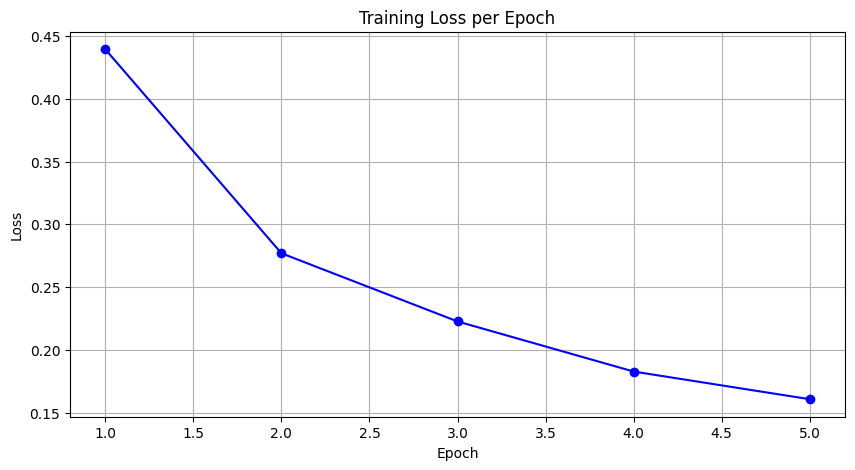

In [6]:
import os
import torch
import matplotlib.pyplot as plt
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn


num_classes = 8  # 7 classes + 1 background
model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)


optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)


train_losses = []


num_epochs = 5


save_path = "model_weights"
os.makedirs(save_path, exist_ok=True)


for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0

    for images, targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()


    avg_epoch_loss = epoch_loss / len(train_loader)
    train_losses.append(avg_epoch_loss)


    torch.save(model.state_dict(), f"{save_path}/faster_rcnn_epoch_{epoch+1}.pth")

    print(f"Epoch {epoch+1}, Loss: {avg_epoch_loss}")

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, marker='o', linestyle='-', color='b')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.savefig("training_loss_graph.png")
plt.show()
